In [1]:
!git clone https://github.com/dercodeKoenig/hft_dqn
!mv hft_dqn/*.py .
!rm -r hft_dqn

Cloning into 'hft_dqn'...


remote: Enumerating objects: 791, done.
remote: Counting objects: 100% (92/92), done.


remote: Compressing objects: 100% (42/42), done.


remote: Total 791 (delta 59), reused 75 (delta 49), pack-reused 699 (from 1)
Receiving objects: 100% (791/791), 378.92 MiB | 39.00 MiB/s, done.


Resolving deltas: 100% (452/452), done.


In [2]:
import threading
import queue
import time
start_time = time.time()
import os
from MultiTimeframeCandleManager import *
from datetime import datetime, timedelta
from collections import deque
import numpy as np
from tqdm import tqdm
import copy
import tensorflow as tf
import random
from save_and_load import *
from Candle import Candle
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (
        Input, Lambda, Concatenate, Dense, Embedding, Dropout, LSTM, 
        MultiHeadAttention, LayerNormalization, LeakyReLU, GlobalAveragePooling1D
    )
#from tensorflow.keras import mixed_precision
#mixed_precision.set_global_policy('mixed_float16')

start_time = time.time()

tpu_mode = True

E0000 00:00:1744629992.559077      74 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


In [3]:


train_data = []

data_dirs = [
    "/kaggle/input/nn-v1-dataprep-nq2",
    "/kaggle/input/nn-v1-dataprep-es2",
    "/kaggle/input/nn-v1-dataprep-ym2",
    "/kaggle/input/nn-v1-dataprep-eu2",
    "/kaggle/input/nn-v1-dataprep-gb2",
]
data_files= []
for d in data_dirs:
    subfiles = os.listdir(d)
    for f in subfiles:
        if "_train_" in f and "_2" in f:
            data_files.append(os.path.join(d,f))
print(data_files)

data_index = 0
def load_new_data():
    global data_index
    data_index+=1
    if data_index >= len(data_files):
        data_index = 0

    file = data_files[data_index]
    data = obj_load(file)
    return data
    

data_queue = queue.Queue(maxsize=1)

def data_loader():
    """Background thread that continuously loads data into the queue."""
    while True:
        # Only load new data if there is room in the queue.
        if data_queue.qsize() < data_queue.maxsize:
            new_data = load_new_data()
            print("new data loaded!")
            data_queue.put(new_data)
        else:
            # Sleep briefly to avoid busy waiting.
            time.sleep(1)

# Start the data loader thread as a daemon so it exits when the main program ends.
if not tpu_mode:
    loader_thread = threading.Thread(target=data_loader, daemon=True)
    loader_thread.daemon = True
    loader_thread.start()

    # because it does not load all, enter distribution by hand:
    c0, c1, c2 = 1454111, 1372224, 11281837

# or load all data at once if it fits in memory
else:
    train_data=[]
    for file in data_files:
                    data = obj_load(file)
                    train_data.extend(data)
                    #break
        #break

    random.shuffle(train_data)
    
   # info about class distribution
    c0 = 0
    c1 = 0
    c2 = 0
    print("info about y distribution:")
    for x,y in train_data:
            if y == -1:
                c0+=1
            if y == 1:
                c1+=1
            if y == 0:
                c2+=1
print("raw distribution:", c0,c1,c2)
l = c0+c1+c2
print("relative distribution:", c0/l,c1/l,c2/l)


['/kaggle/input/nn-v1-dataprep-nq2/NQ_2_train_2', '/kaggle/input/nn-v1-dataprep-nq2/NQ_2_train_3', '/kaggle/input/nn-v1-dataprep-nq2/NQ_2_train_1', '/kaggle/input/nn-v1-dataprep-nq2/NQ_2_train_0', '/kaggle/input/nn-v1-dataprep-es2/ES_2_train_0', '/kaggle/input/nn-v1-dataprep-es2/ES_2_train_1', '/kaggle/input/nn-v1-dataprep-es2/ES_2_train_3', '/kaggle/input/nn-v1-dataprep-es2/ES_2_train_2', '/kaggle/input/nn-v1-dataprep-ym2/YM_2_train_0', '/kaggle/input/nn-v1-dataprep-ym2/YM_2_train_3', '/kaggle/input/nn-v1-dataprep-ym2/YM_2_train_2', '/kaggle/input/nn-v1-dataprep-ym2/YM_2_train_1', '/kaggle/input/nn-v1-dataprep-eu2/EURUSD_2_train_0', '/kaggle/input/nn-v1-dataprep-eu2/EURUSD_2_train_1', '/kaggle/input/nn-v1-dataprep-gb2/GBPUSD_2_train_0', '/kaggle/input/nn-v1-dataprep-gb2/GBPUSD_2_train_1']
loading /kaggle/input/nn-v1-dataprep-nq2/NQ_2_train_2


loading /kaggle/input/nn-v1-dataprep-nq2/NQ_2_train_3


loading /kaggle/input/nn-v1-dataprep-nq2/NQ_2_train_1


loading /kaggle/input/nn-v1-dataprep-nq2/NQ_2_train_0


loading /kaggle/input/nn-v1-dataprep-es2/ES_2_train_0


loading /kaggle/input/nn-v1-dataprep-es2/ES_2_train_1


loading /kaggle/input/nn-v1-dataprep-es2/ES_2_train_3


loading /kaggle/input/nn-v1-dataprep-es2/ES_2_train_2


loading /kaggle/input/nn-v1-dataprep-ym2/YM_2_train_0


loading /kaggle/input/nn-v1-dataprep-ym2/YM_2_train_3


loading /kaggle/input/nn-v1-dataprep-ym2/YM_2_train_2


loading /kaggle/input/nn-v1-dataprep-ym2/YM_2_train_1


loading /kaggle/input/nn-v1-dataprep-eu2/EURUSD_2_train_0


loading /kaggle/input/nn-v1-dataprep-eu2/EURUSD_2_train_1


loading /kaggle/input/nn-v1-dataprep-gb2/GBPUSD_2_train_0


loading /kaggle/input/nn-v1-dataprep-gb2/GBPUSD_2_train_1


info about y distribution:


raw distribution: 1455683 1373637 11289934
relative distribution: 0.1030991439066115 0.09728821366907912 0.7996126424243094


In [4]:

## TODO: maybe split back to 3x60 before final lstm?


def make_model():
    dropout_rate = 0.05  # adjust as needed

     ### Define helper to process a chart input (shape: (60,5))
    def process_chart(chart_input, name):
        # Separate OHLC (first 4 columns) and time (5th column)
        ohlc = Lambda(lambda x: tf.clip_by_value(x[:, :, :4], -1000.0, 1000.0), name=f'{name}_clip_ohlc')(chart_input)
        t = Lambda(lambda x: x[:, :, 4], name=f'{name}_extract_time')(chart_input)
        # Wrap tf.cast in a Lambda so that it's applied as a Keras operation
        t_int = Lambda(lambda x: tf.cast(x, tf.int32), name=f'{name}_cast_time')(t)
        # Embed the per-candle time (assumes integer inputs; adjust input_dim as appropriate)
        t_embed = Embedding(input_dim=60*24, output_dim=8, name=f'{name}_t_embed')(t_int)
        # Concatenate OHLC (4 dims) with the embedded time (8 dims) => result shape: (60, 12)
        return Concatenate(name=f'{name}_concat')([ohlc, t_embed])
    
    ### Inputs
    # Each chart now is (60,5): OHLC + per-candle time
    chart_m15 = Input(shape=(60,5), name='chart_m15')
    chart_m5  = Input(shape=(60,5), name='chart_m5')
    chart_m1  = Input(shape=(60,5), name='chart_m1')
    
    # PDAs input (same as before) and clip it (do not clip minutes here)
    pdas = Input(shape=(3*3 + 3*3 + 1 + 12*5 + 5*3,), name='pdas')
    pdas = Lambda(lambda x: tf.clip_by_value(x, -1000.0, 1000.0), name='clip_pdas')(pdas)
    
    # Global minutes input remains
    minutes = Input(shape=(1,), name='minutes')
    minutes_embed = Embedding(input_dim=60*24, output_dim=8, name='global_minutes_embed')(minutes)  # shape (batch, 1, 8)
    
    ### Process each chart
    m15_processed = process_chart(chart_m15, 'm15')
    m5_processed  = process_chart(chart_m5, 'm5')
    m1_processed  = process_chart(chart_m1, 'm1')

    m15_with_tf = Concatenate(axis=-1, name='m15_with_tf')([
        m15_processed,
        Lambda(lambda x: tf.tile(tf.reshape(tf.constant([1., 0., 0.], dtype=tf.float32), (1, 1, 3)), 
                                 [tf.shape(x)[0], tf.shape(x)[1], 1]),
               name='m15_timeframe')(m15_processed)
    ])
    
    m5_with_tf = Concatenate(axis=-1, name='m5_with_tf')([
        m5_processed,
        Lambda(lambda x: tf.tile(tf.reshape(tf.constant([0., 1., 0.], dtype=tf.float32), (1, 1, 3)), 
                                 [tf.shape(x)[0], tf.shape(x)[1], 1]),
               name='m5_timeframe')(m5_processed)
    ])
    
    m1_with_tf = Concatenate(axis=-1, name='m1_with_tf')([
        m1_processed,
        Lambda(lambda x: tf.tile(tf.reshape(tf.constant([0., 0., 1.], dtype=tf.float32), (1, 1, 3)), 
                                 [tf.shape(x)[0], tf.shape(x)[1], 1]),
               name='m1_timeframe')(m1_processed)
    ])
    
    # Concatenate the charts along the time axis: resulting in shape (batch, 180, feature_dim)
    combined_charts = Concatenate(axis=1, name='charts_concat')([m15_with_tf, m5_with_tf, m1_with_tf])
    # At this point, each time step has 12 features (4 from OHLC + 8 from time embed)
    
    ### Repeat pdas and global minutes so they are added to every candle
    # Repeat PDAs to get shape (batch, 180, pdas_dim)
    pdas_repeated = Lambda(
        lambda x: tf.repeat(tf.expand_dims(x, axis=1), repeats=180, axis=1),
        name='pdas_repeated')(pdas)

    # Concat the charts with the repeated PDAs and minutes
    combined_sequence = Concatenate(axis=-1, name='combined_sequence')(
        [combined_charts, pdas_repeated]
    )
    # Now, if combined_charts has 12 features, pdas has, say, 94 dims, and global minutes 8 dims,
    # each time step will have 12 + 94 = 106 features.
    
    ### Define a transformer encoder block (like in a Transformer encoder)
    def transformer_encoder(inputs, head_dim, num_heads, ff_dim, dropout_rate, name):
        # Multi-head self-attention
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_dim, name=f'{name}_mha')(inputs, inputs)
        attn_output = Dropout(dropout_rate, name=f'{name}_attn_dropout')(attn_output)
        #out1 = LayerNormalization(epsilon=1e-6, name=f'{name}_attn_ln')(inputs + attn_output)
        out1 = inputs + attn_output
        # Feed-forward network
        ffn_output = Dense(ff_dim, activation='relu', name=f'{name}_ffn_dense1')(out1)
        ffn_output = Dense(inputs.shape[-1], name=f'{name}_ffn_dense2')(ffn_output)
        ffn_output = Dropout(dropout_rate, name=f'{name}_ffn_dropout')(ffn_output)
        #out2 = LayerNormalization(epsilon=1e-6, name=f'{name}_ffn_ln')(out1 + ffn_output)
        out2 = out1 + ffn_output
        return out2
    
    ### Apply transformer layers
    x = combined_sequence
    # convert the concat ohlc+t+pda to vector
    x = Dense(1024)(x)
    x = LeakyReLU(0.05)(x)
    x = Dense(4096)(x)
    x = LeakyReLU(0.05)(x)
    x = Dense(4096)(x)
    x = LeakyReLU(0.05)(x)
    x = Dense(128)(x)
    x = LeakyReLU(0.05)(x)


    # Feature dim after your Dense layers
    feature_dim = 128
    
    # Define learnable CLS token
    cls_token = tf.Variable(
        initial_value=tf.random.normal(shape=(1, 1, feature_dim)),
        trainable=True,
        name="cls_token"
    )
    
    # Wrap it in a Lambda so it works with batch size
    def prepend_cls(x):
        batch_size = tf.shape(x)[0]
        cls_broadcasted = tf.tile(cls_token, [batch_size, 1, 1])  # shape: (batch, 1, feature_dim)
        return tf.concat([cls_broadcasted, x], axis=1)
    
    x = Lambda(prepend_cls, name="prepend_cls_token")(x)

    
    x = transformer_encoder(x, head_dim=256, num_heads=32, ff_dim=512, dropout_rate=dropout_rate, name='trans_enc1')
    x = transformer_encoder(x, head_dim=256, num_heads=32, ff_dim=512, dropout_rate=dropout_rate, name='trans_enc2')
    x = transformer_encoder(x, head_dim=256, num_heads=32, ff_dim=512, dropout_rate=dropout_rate, name='trans_enc3')
    x = transformer_encoder(x, head_dim=256, num_heads=32, ff_dim=512, dropout_rate=dropout_rate, name='trans_enc4')
    x = transformer_encoder(x, head_dim=256, num_heads=32, ff_dim=512, dropout_rate=dropout_rate, name='trans_enc5')
    x = transformer_encoder(x, head_dim=256, num_heads=32, ff_dim=512, dropout_rate=dropout_rate, name='trans_enc6')
    x = transformer_encoder(x, head_dim=256, num_heads=32, ff_dim=512, dropout_rate=dropout_rate, name='trans_enc7')
    x = Lambda(lambda t: t[:, 0, :], name="extract_cls")(x)

    
    ### Summarize the sequence with an LSTM layer
    #lstm_out = LSTM(1024, return_sequences=False, name='final_lstm')(x)
    #x = tf.keras.layers.Flatten(name="flat")(x)
    
    
    ### Final dense tower
    d = Dense(4096, name='dense1')(x)
    d = LeakyReLU(0.05)(d)
    d = Dropout(0.1)(d)  # slightly increased dropout rate (tweak as needed)
    
    d = Dense(4096, name='dense2')(d)
    d = LeakyReLU(0.05)(d)
    d = Dropout(0.1)(d)
    
    d = Dense(4096, name='dense3')(d)
    d = LeakyReLU(0.05)(d)
    d = Dropout(0.1)(d)
    
    d = Dense(4096, name='dense4')(d)
    d = LeakyReLU(0.05)(d)
    d = Dropout(0.1)(d)

    ### Add Tanh before the softmax to stabilize the output
    d = Dense(1024, activation='tanh', name='pre_softmax_tanh')(d)  #
    
    ### Final output layer (3-class softmax)
    output = Dense(3, activation="softmax", dtype="float32", name='output')(d)
    
    ### Create and compile model
    model = tf.keras.Model(
        inputs=[chart_m15, chart_m5, chart_m1, pdas, minutes],
        outputs=output
    )

    return model

In [5]:
if tpu_mode:
        cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
        tf.config.experimental_connect_to_cluster(cluster_resolver)
        tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
        strategy = tf.distribute.TPUStrategy(cluster_resolver)
        #strategy = tf.distribute.MirroredStrategy()    

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1744630684.066755      74 service.cc:148] XLA service 0x5b18dac3cbd0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744630684.066806      74 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1744630684.066810      74 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1744630684.066813      74 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1744630684.066816      74 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1744630684.066819      74 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1744630684.066822      74 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8


I0000 00:00:1744630684.066824      74 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1744630684.066827      74 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


In [6]:

lr = 0.00001

if tpu_mode:
    with strategy.scope():
        model = make_model()
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0)
else:
    model = make_model()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0)
    
model.summary()


I0000 00:00:1744630689.194316      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ chart_m15           │ (None, 60, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ chart_m5            │ (None, 60, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ chart_m1            │ (None, 60, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ m15_extract_time    │ (None, 60)        │          0 │ chart_m15[1][0]   │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ m5_extract_time     │ (None, 60)        │          0 │ chart_m5[1][0]    │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ m1_extract_time     │ (None, 60)        │          0 │ chart_m1[1][0]    │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ m15_cast_time       │ (None, 60)        │          0 │ m15_extract_time… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ m5_cast_time        │ (None, 60)        │          0 │ m5_extract_time[… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ m1_cast_time        │ (None, 60)        │          0 │ m1_extract_time[… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ m15_clip_ohlc       │ (None, 60, 4)     │          0 │ chart_m15[1][0]   │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ m15_t_embed         │ (None, 60, 8)     │     11,520 │ m15_cast_time[1]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ m5_clip_ohlc        │ (None, 60, 4)     │          0 │ chart_m5[1][0]    │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ m5_t_embed          │ (None, 60, 8)     │     11,520 │ m5_cast_time[1][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ m1_clip_ohlc        │ (None, 60, 4)     │          0 │ chart_m1[1][0]    │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ m1_t_embed          │ (None, 60, 8)     │     11,520 │ m1_cast_time[1][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ m15_concat          │ (None, 60, 12)    │          0 │ m15_clip_ohlc[1]… │
│ (Concatenate)       │                   │            │ m15_t_embed[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ m5_concat           │ (None, 60, 12)    │          0 │ m5_clip_ohlc[1][

 Total params: 107,177,091 (408.85 MB)

 Trainable params: 107,177,091 (408.85 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [8]:
model.load_weights("/kaggle/input/nn-train-v7/model.weights.h5")
print("weights loaded!")

weights loaded!


In [9]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)

 
class_counts = np.array([c0, c1, c2])
class_weights = class_counts.sum() / (len(class_counts) * class_counts)
class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)
print("weights:", class_weights_tensor)


tf.function(jit_compile=True) # my gpu does not support this
def tstep(data):
    x, y = data

    with tf.GradientTape() as t:
        model_return = model(x, training=True)
        #print(y, model_return)
        loss = loss_fn(y, model_return)
        #print(loss)
        

        # Apply class weights
        sample_weights = tf.reduce_sum(y * class_weights_tensor, axis=-1)  # Select the correct weight for each sample
        loss = loss * sample_weights  # Multiply loss by sample weights

        loss = tf.reduce_mean(loss)

        
        #if loss > 10:
        #    loss *= 0.1  # Scale down the loss if it's greater than 10, probably data point error

    predicted_class = tf.argmax(model_return, axis=-1)
    true_class = tf.argmax(y, axis=-1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted_class, true_class), tf.float32))
            
    
    gradient = t.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradient, model.trainable_variables))

    return loss, accuracy


batch_size = 64

def get_data(_):
    global train_data

    while len(train_data) < 10000:
        if not data_queue.empty():
            new_data = data_queue.get(timeout=1)  # wait up to 1 second for data
            train_data.extend(new_data)
        else:
            # If no new data is available, break out of the loop.
            print("waiting for data....")
            time.sleep(1)
            continue
    
    # Pop a batch of data from the front.
    train_sample = train_data[:batch_size]
    train_data = train_data[batch_size:]

    # Extract multiple input features
    states = [x[0] for x in train_sample]  # Extract input features (list of lists)
    states_array = [
        np.array([sample[i] for sample in states], dtype="float32") for i in range(len(states[0]))
    ]  # Convert each input feature to an array

    # Convert to TensorFlow tensors
    states_tensor = [tf.convert_to_tensor(arr) for arr in states_array]

    # Extract targets and convert to tensor
    targets = []
    for x in train_sample:
      v = x[1]
      if v == 1:
        targets.append([0,1,0])
      elif v == -1:
        targets.append([1,0,0])
      else:
        targets.append([0,0,1])
    
    targets_tensor = tf.convert_to_tensor(np.array(targets, dtype="float32"))

    return states_tensor, targets_tensor  # Return tuple (list of tensors, labels tensor)





train_index = 0
def get_data_2(_):
    global train_index
    train_sample = [train_data[i] for i in range(train_index, train_index + batch_size)]
    train_index += batch_size
    if train_index + batch_size >= len(train_data):
        train_index = 0
        random.shuffle(train_data)

    # Extract multiple input features
    states = [x[0] for x in train_sample]  # Extract input features (list of lists)
    states_array = [
        np.array([sample[i] for sample in states], dtype="float32") for i in range(len(states[0]))
    ]  # Convert each input feature to an array

    # Convert to TensorFlow tensors
    states_tensor = [tf.convert_to_tensor(arr) for arr in states_array]

    # Extract targets and convert to tensor
    targets = []
    for x in train_sample:
      v = x[1]
      if v == 1:
        targets.append([0,1,0])
      elif v == -1:
        targets.append([1,0,0])
      else:
        targets.append([0,0,1])
    targets_tensor = tf.convert_to_tensor(np.array(targets, dtype="float32"))

    return states_tensor, targets_tensor  # Return tuple (list of tensors, labels tensor)


weights: tf.Tensor([3.2331338 3.4262457 0.4168685], shape=(3,), dtype=float32)


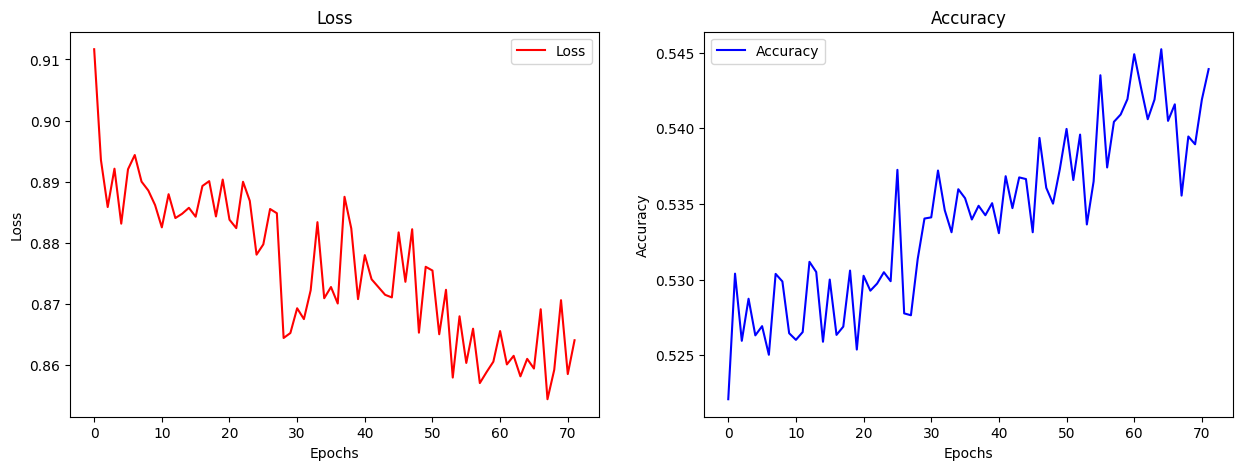

71 0.86400294 0.5439063


In [10]:
@tf.function(reduce_retracing=True)
def run(data):
    return strategy.reduce(tf.distribute.ReduceOp.MEAN, strategy.run(tstep, args = (data,)), axis = None)

import IPython

loss_lt = []
acc_lt = []

for n in range(1000):
    losses_st = []
    acc_st = []
    #for _ in tqdm(range(1000)):
    for _ in range(1000):
        if tpu_mode:
            #distributed_data = (strategy.experimental_distribute_values_from_function(get_data))
            distributed_data = (strategy.experimental_distribute_values_from_function(get_data_2))
            loss, acc = run(distributed_data)
        else:
            data = get_data(None)
            loss, acc = tstep(data)
        losses_st.append(loss)
        acc_st.append(acc)
    
    loss_lt.append(np.mean(losses_st))
    acc_lt.append(np.mean(acc_st))

    
    IPython.display.clear_output()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot Loss
    ax1.plot(loss_lt, label="Loss", color="red")
    ax1.set_title("Loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()

    # Plot Accuracy
    ax2.plot(acc_lt, label="Accuracy", color="blue")
    ax2.set_title("Accuracy")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend()

    plt.show()
    #print(loss_lt, acc_lt)
    print(n, loss_lt[-1], acc_lt[-1])

    if time.time() - start_time > 60*60*8.5:
        break


In [11]:
model.save_weights("model.weights.h5")